<h1><center> Frontal Low-Level Jet analysis  </center></h1>
<div style="text-align: center"> 
    Dr. Harish Baki <br/> Postdoctoral researcher <br/> TU Delft, Netherlands <br/> Email: h.baki@tudelft.nl<br/>
</div>

In [1]:
# print current date
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2024-11-19 00:48:26


In [40]:
import xarray as xr
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

root_dir = '/media/ssd_4tb_qvo/EU_SCORES_project/WRFV4.4/FLLJ/'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)

from data_processing.libraries import *

fig_dir = '/home/harish/Dropbox/Apps/Overleaf/Modelling Frontal Low-level Jets and Associated Extreme Wind Ramps'


In [9]:
import dask.distributed as dd

if 'client' in locals():
    client.close()
    cluster.close()

cluster = dd.LocalCluster(n_workers=24, threads_per_worker=2, memory_limit='2GB',dashboard_address=f':22522')
client = dd.Client(cluster)
print(client)

<Client: 'tcp://127.0.0.1:36059' processes=24 threads=48, memory=44.70 GiB>


In [41]:
buoy_locations = {'LOT1': [51.706898,3.034618], 'LOT2': [51.6463,2.95141]}
subplot_letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [42]:
case = 1
case_dir = f'FLLJ_{case}'
run = 2
run_dir = f'WRF_run_{run}'
file = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/auxhist22_d01*')[0]
chunks={"Time": 1,"south_north": -1,"west_east": -1}
ds = xr.open_dataset(file,chunks=chunks)
ds.Times.values

array([b'2016-02-21_12:00:00', b'2016-02-21_18:00:00',
       b'2016-02-22_00:00:00', b'2016-02-22_06:00:00',
       b'2016-02-22_12:00:00', b'2016-02-22_18:00:00'], dtype='|S19')

In [43]:
case = 1
case_dir = f'FLLJ_{case}'
run = 2
run_dir = f'WRF_run_{run}'
file = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/auxhist22_{domains[run-1]}*')[0]
chunks={"Time": 1,"south_north": -1,"west_east": -1}
ds = xr.open_dataset(file,chunks=chunks)
Times = pd.to_datetime(np.char.decode(ds.Times, 'utf-8'), format='%Y-%m-%d_%H:%M:%S')
z = ds.Z_ZL[0,...].values
ds = ds.assign_coords(Time=Times,num_z_levels_stag=z)
# Extract XLONG and XLAT coordinates
XLONG = ds.XLONG[0,...]#.values
XLAT = ds.XLAT[0,...]#.values

dates_range = ramp_periods[case-1]
levels = 60.
u,v,XLONG,XLAT = extract_u_v(root_dir,case_dir,run,run_dir,dates_range,levels)
ws = wind_speed(u,v)

In [44]:
def map_plotter(fig,gs,data,x,y,levels,cmap,title,cbar_args,extent=None,rectangles=None,sample_points=None,turbine_locs=False,bottom_labels=False,left_labels=False,norm=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()

    contour = data.plot.contourf(
        x=x,y=y,levels=levels,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':14},
        ax=ax, norm = norm)
    
    # Add colorbar with font size
    if cbar_args is not None:
        cbar = fig.colorbar(contour, orientation=cbar_args['orientation'], shrink=cbar_args['shrink'], aspect=40, label=cbar_args['cbar_label'])
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xlabel(cbar_args['cbar_label'], fontsize=12)
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False 
    gl.bottom_labels = False
    if bottom_labels:
        gl.bottom_labels = True
    if left_labels:
        gl.left_labels = True
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    # set title
    ax.set_title(title,fontsize=14)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=14, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    if turbine_locs:
        ds = xr.open_dataset(f'{root_dir}/borssele_wind_turbines.nc')
        for i in range(len(ds.lon)):
            ax.plot(ds.lon[i], ds.lat[i], '.', markersize=0.5,color='black')
    return ax

In [45]:
ramp_periods = [['2016-02-22T00:00','2016-02-22T12:00'],['2016-03-04T00:00','2016-03-04T12:00']]

2016-02-22_04:00:00
2016-02-22_04:30:00
2016-02-22_05:00:00
2016-02-22_05:30:00
2016-02-22_06:00:00
2016-02-22_06:30:00
2016-02-22_07:00:00
2016-02-22_07:30:00
2016-02-22_04:00:00
2016-02-22_04:30:00
2016-02-22_05:00:00
2016-02-22_05:30:00
2016-02-22_06:00:00
2016-02-22_06:30:00
2016-02-22_07:00:00
2016-02-22_07:30:00
2016-03-04_05:00:00
2016-03-04_05:30:00
2016-03-04_06:00:00
2016-03-04_06:30:00
2016-03-04_07:00:00
2016-03-04_07:30:00
2016-03-04_08:00:00
2016-03-04_08:30:00
2016-03-04_05:00:00
2016-03-04_05:30:00
2016-03-04_06:00:00
2016-03-04_06:30:00
2016-03-04_07:00:00
2016-03-04_07:30:00
2016-03-04_08:00:00
2016-03-04_08:30:00


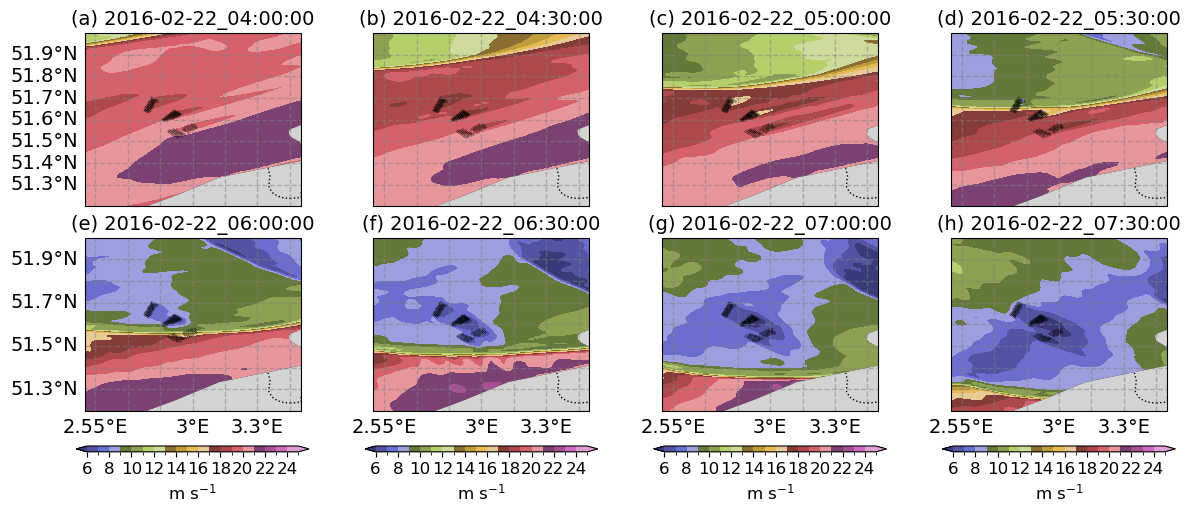

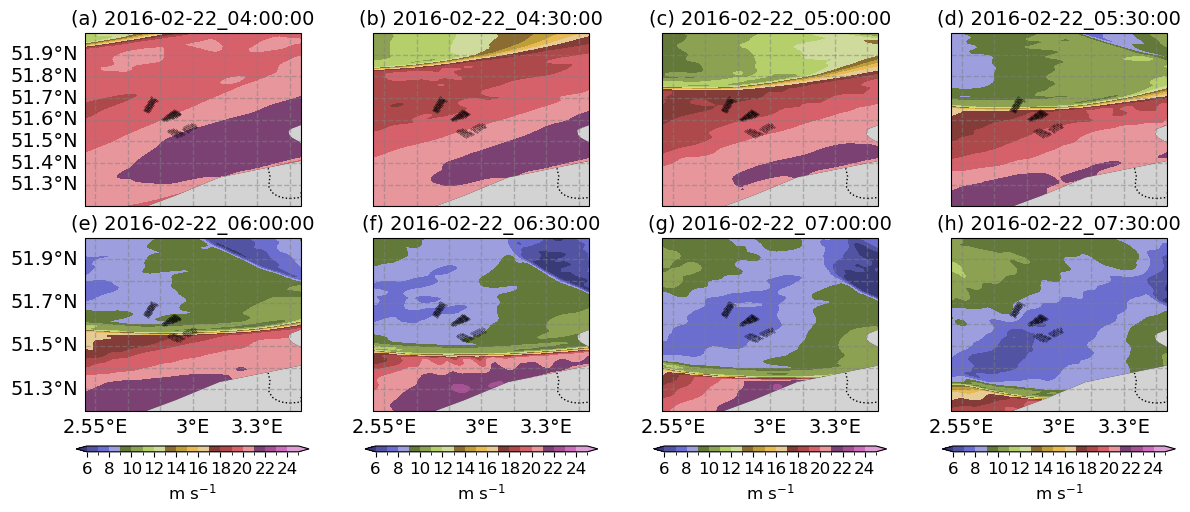

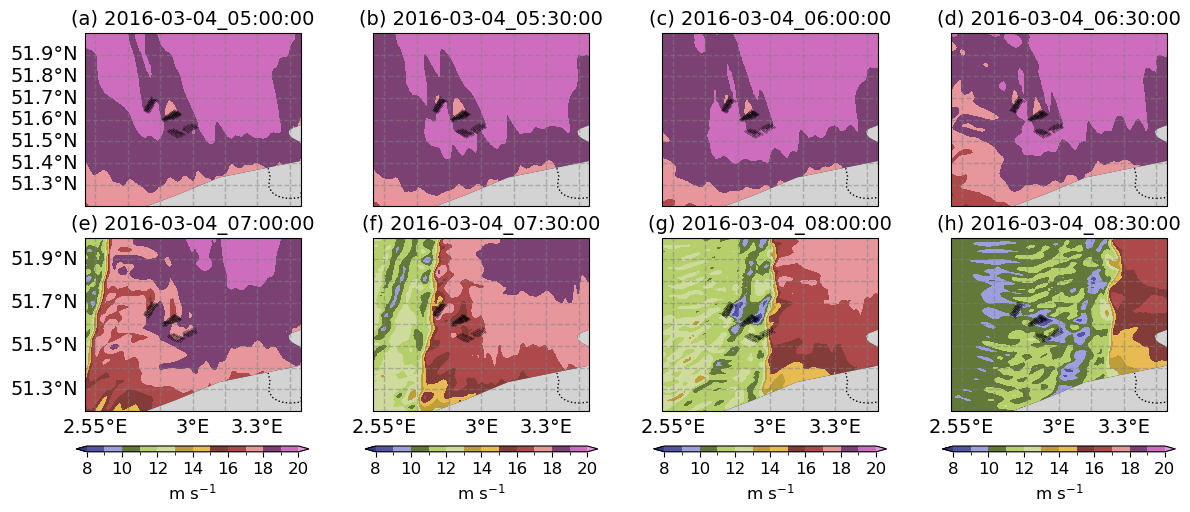

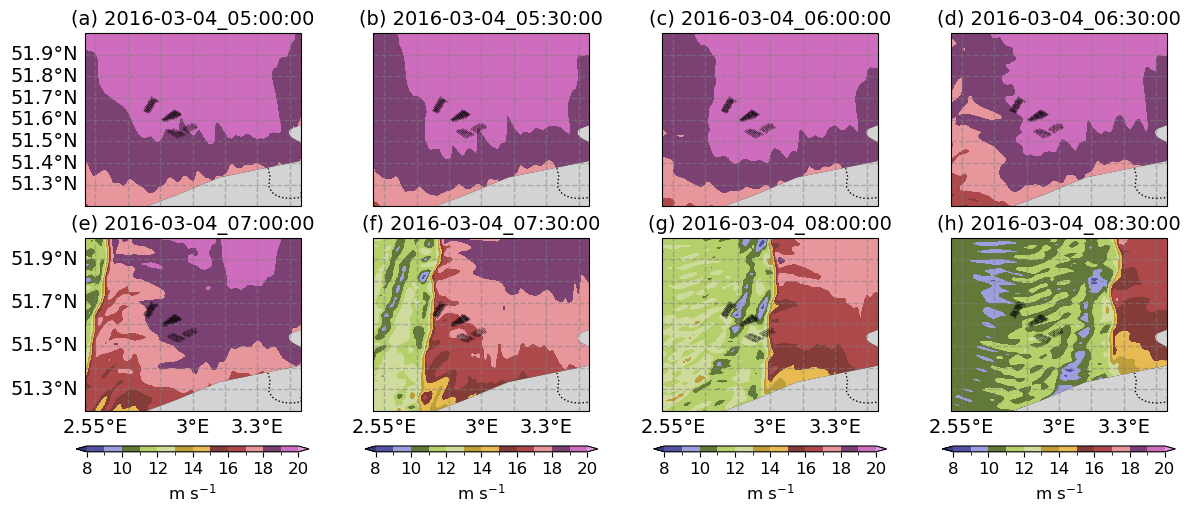

In [49]:
for case in [1,2]:
    if case ==1:
        levels = np.arange(6,25.1,1)
        from matplotlib.colors import ListedColormap, BoundaryNorm
        # Create a custom colormap with 20 distinct colors
        cmap = plt.get_cmap('tab20b', len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
        norm = BoundaryNorm(levels, cmap.N)
    else:
        levels = np.arange(8,20.1,1)
        from matplotlib.colors import ListedColormap, BoundaryNorm
        # Create a custom colormap with 20 distinct colors
        cmap = plt.get_cmap('tab20b', len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
        norm = BoundaryNorm(levels, cmap.N)

    case_dir = f'FLLJ_{case}'
    for run in [2,3]:
        run_dir = f'WRF_run_{run}' #if run == 1 else f'WRF_run_{run+7}'
        file = glob.glob(f'{root_dir}/{case_dir}/{run_dir}/auxhist22_{domains[run-1]}*')[0]
        chunks={"Time": 1,"south_north": -1,"west_east": -1}
        ds = xr.open_dataset(file,chunks=chunks)
        Times = pd.to_datetime(np.char.decode(ds.Times, 'utf-8'), format='%Y-%m-%d_%H:%M:%S')
        z = ds.Z_ZL[0,...].values
        ds = ds.assign_coords(Time=Times,num_z_levels_stag=z)
        # Extract XLONG and XLAT coordinates
        XLONG = ds.XLONG[0,...]#.values
        XLAT = ds.XLAT[0,...]#.values

        dates_range = ramp_periods[case-1]
        levels = 100.
        u,v,XLONG,XLAT = extract_u_v(root_dir,case_dir,run,run_dir,dates_range,levels)
        ws = wind_speed(u,v)

        extent = [2.5, 3.5, 51.2, 52]
        # create cmap for wind speed with increasing intensity of blues
        cmap = plt.get_cmap('tab20b') #'Blues', 20)
        fig = plt.figure(figsize=(12, 5), constrained_layout=True)
        gs = fig.add_gridspec(2,4)
        cbar_args = {'shrink':0.8,'cbar_label':f'm/s','orientation':'horizontal'}
        # create 6 time slices from 2016-02-22T05:30 to 2016-02-22T06:30, at every 10 minutes
        # Extract the first date from ramp_period
        first_date = datetime.fromisoformat(ramp_periods[case-1][0])
        # Add 3 hours to the first date to get the start slice
        
        start_slice = first_date + timedelta(hours=4) if case == 1 else first_date + timedelta(hours=5)
        time_slices = [start_slice + timedelta(minutes=30)*i for i in range(8)]

        for i,slice in enumerate(time_slices):
            date = slice
            date = pd.to_datetime(date).strftime('%Y-%m-%d_%H:%M:%S')
            print(date)

            bottom_labels = False if i//4 != 1  else True
            left_labels = False if i % 4 != 0 else True
            cbar_args = {'shrink':0.83,'cbar_label':'$\mathrm{m\ s^{-1}}$','orientation':'horizontal'} if i//4 == 1 else None
            title = f'({subplot_letters[i]}) {date}'
            axs = map_plotter(fig,gs[i//4,i%4],ws.sel(Time=slice,method='nearest'),'XLONG','XLAT',
                            np.arange(0,31,2),cmap,title,cbar_args,
                            sample_points = None,extent=extent,turbine_locs=True,bottom_labels=bottom_labels,left_labels=left_labels,norm=norm)
        plt.savefig(f'{fig_dir}/{case_dir}_wind_speed_{run}(3hCERRA).png',dpi=300)


In [72]:
for j in range(len(turbine_lats)):
    print(j,turbine_lats[j],turbine_lons[j],ds.XLAT[j,0].values,ds.XLONG[j,0].values)

0 51.619688 2.923733 51.61892 2.9221497
1 51.623522 2.92744 51.623474 2.9293823
2 51.627353 2.93116 51.627987 2.9293213
3 51.631108 2.934775 51.632526 2.9365234
4 51.628472 2.939163 51.62802 2.9365845
5 51.6259 2.943438 51.62805 2.9438477
6 51.624713 2.935557 51.62351 2.9366455
7 51.620937 2.934933 51.61899 2.936676
8 51.617587 2.929093 51.61896 2.9294128
9 51.622328 2.919338 51.623432 2.9220886
10 51.626162 2.923043 51.627953 2.9220276
11 51.629995 2.926765 51.627987 2.9293213
12 51.63375 2.93038 51.632492 2.9292603
13 51.636392 2.925983 51.637012 2.9291992
14 51.632635 2.922368 51.632465 2.921997
15 51.628802 2.918662 51.627953 2.9220276
16 51.62497 2.914942 51.6234 2.9148254
17 51.631443 2.914265 51.632427 2.9147034
18 51.635275 2.917985 51.63694 2.9146729
19 51.639033 2.92159 51.636974 2.921936
20 51.641675 2.917195 51.641453 2.9146118
21 51.637917 2.913588 51.63694 2.9146729
22 51.634083 2.909867 51.63239 2.9074402
23 51.637648 2.903345 51.636868 2.900116
24 51.641015 2.909203 51.

In [85]:
hub_heights

[71, 72, 94, 94, 100]

In [82]:
turbine_types[90]

4

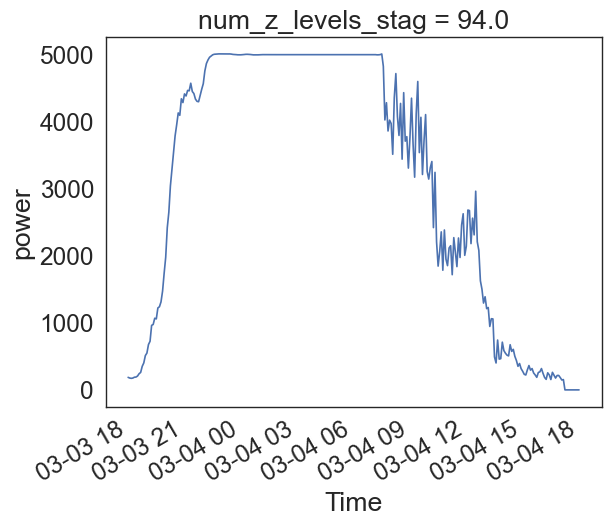

In [88]:
ds.power.sel(turbine=99).plot()

In [51]:
j = 0
location = [turbine_lats[j],turbine_lons[j]]
power_curve = power_curves[turbine_types[j]-1]
levels = hub_heights[turbine_types[j]-1]
ind_y,ind_x = find_nearest_indice(XLAT, XLONG, location[0],location[1])
ind_y,ind_x
location, XLAT[ind_y,ind_x], XLONG[ind_y,ind_x]

Closest indices in the order of latitude (y) and longitude (x) are : (304, 220)


([51.619688, 2.923733], 51.61892, 2.9221497)

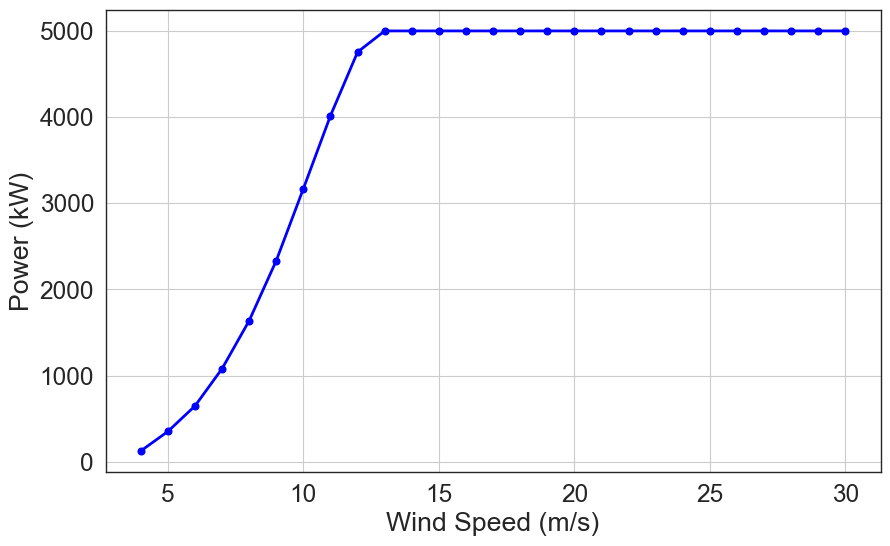

In [93]:
# Create a scatter plot of the power curve
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
plt.figure(figsize=(10, 6))
plt.plot(power_curve.iloc[:,0], power_curve.iloc[:,1], color='blue', marker='o',linestyle='-',linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
#plt.title('15MW Turbine Power Curve')
plt.grid(True)
#plt.legend()